In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
import math
import random

In [2]:
class SVPWM():
    def __init__(self, Ts=0.001, offset=50, duty_selection=True):
        self.Ts = Ts
        self.offset = offset
        self.duty_selection = duty_selection

        self.sys = control.NonlinearIOSystem(
            None, self.duty_ref,
            inputs=["u_ref_a", "u_ref_b", "u_ref_c"],
            outputs=["duty_a_ref", "duty_b_ref", "duty_c_ref"],
            name='svpwm',
            dt=self.Ts
        )

    def selector(self, u_a, u_b, u_c):
        # Element-wise selection using numpy operations
        conditions = [
            (u_a >= u_b) & (u_c >= u_a),  # Condition for sector 5
            (u_a >= u_b) & (u_c < u_a) & (u_c >= u_b),  # Condition for sector 6
            (u_a >= u_b) & (u_c < u_b),  # Condition for sector 1
            (u_a < u_b) & (u_a >= u_c),  # Condition for sector 2
            (u_a < u_b) & (u_a < u_c) & (u_b >= u_c),  # Condition for sector 3
            (u_a < u_b) & (u_b < u_c)  # Condition for sector 4
        ]
        values = [5, 6, 1, 2, 3, 4]
        return np.select(conditions, values, default=1)  # Default to sector 1 if none match
    
    def duty_offset(self, offset, u_a, u_b, u_c):
        sector = self.selector(u_a, u_b, u_c)
        
        # Compute duty cycles based on sector
        duty_a = np.zeros_like(u_a)
        duty_b = np.zeros_like(u_b)
        duty_c = np.zeros_like(u_c)
        
        mask1 = (sector == 1) | (sector == 4)
        mask2 = (sector == 2) | (sector == 5)
        mask3 = (sector == 3) | (sector == 6)
        
        duty_a[mask1] = offset + offset * (u_a[mask1] - u_c[mask1])
        duty_b[mask1] = offset + offset * (2 * u_b[mask1] - u_a[mask1] - u_c[mask1])
        duty_c[mask1] = offset + offset * (u_c[mask1] - u_a[mask1])
        
        duty_a[mask2] = offset + offset * (2 * u_a[mask2] - u_b[mask2] - u_c[mask2])
        duty_b[mask2] = offset + offset * (u_b[mask2] - u_c[mask2])
        duty_c[mask2] = offset + offset * (u_c[mask2] - u_b[mask2])
        
        duty_a[mask3] = offset + offset * (u_a[mask3] - u_b[mask3])
        duty_b[mask3] = offset + offset * (u_b[mask3] - u_a[mask3])
        duty_c[mask3] = offset + offset * (2 * u_c[mask3] - u_a[mask3] - u_b[mask3])
        
        return duty_a, duty_b, duty_c

    def duty(self, u_ref_a, u_ref_b, u_ref_c, u_bat):
        u_bat_safe = np.where(u_bat == 0, 1e-6, u_bat)  # Avoid division by zero
        u_a = u_ref_a / u_bat_safe
        u_b = u_ref_b / u_bat_safe
        u_c = u_ref_c / u_bat_safe

        duty_a, duty_b, duty_c = self.duty_offset(self.offset, u_a, u_b, u_c)
        
        if not self.duty_selection:
            duty_a = u_a * 100 + 50
            duty_b = u_b * 100 + 50
            duty_c = u_c * 100 + 50
        
        duty_a_ref = np.clip(duty_a, 0, 100)
        duty_b_ref = np.clip(duty_b, 0, 100)
        duty_c_ref = np.clip(duty_c, 0, 100)

        return duty_a_ref, duty_b_ref, duty_c_ref
    
    def duty_ref(self, t, x, u, params):
        u_bat=params.get('u_bat', 400)
        u_ref_a, u_ref_b, u_ref_c = u
        return self.duty(u_ref_a, u_ref_b, u_ref_c, u_bat)

In [3]:
class CurrentController:
    def __init__(self, Ts=0.01, K=30, Kp=1.1, dq_max_voltage=400, i_s_max = 350, p=3):
        self.Ts = Ts
        self.K = K
        self.Kp = Kp
        self.dq_max_voltage = dq_max_voltage
        self.i_smax = i_s_max
        self.p = p

        # Define Transfer Functions
        self.H_delay = control.TransferFunction([1], [1, 0], Ts)  # 1/z (Unit delay)

        self.proportional = control.tf([Kp], [1], Ts, inputs='e', outputs='u_p')
        self.H_integrator = control.tf([K*Ts], [1, -1], Ts, inputs='e', outputs='u_int')  # K*Ts / (z - 1)
        self.error = control.summing_junction(['i_ref', '-current'], 'e') # e = i_ref-current
        self.prop_with_decoupl = control.summing_junction(['u_p', 'u_decoupl'], 'u_pdc')
        self.control_sum = control.summing_junction(['u_pdc', 'u_int'], 'u')
        self.system = control.interconnect(
                    [self.H_integrator, self.proportional, self.error, self.prop_with_decoupl, self.control_sum],
                    inputs=['i_ref', 'current', 'u_decoupl'],
                    outputs='u')

        self.sys_d = control.TransferFunction.copy(self.system, name='sys_d')
        self.sys_q = control.TransferFunction.copy(self.system, name='sys_q')

        self.ref_trans_sys = control.NonlinearIOSystem(
            None, self.ref_trans_gen,
            inputs=["t_mot_ref", "alpha_e", "w_e", "i_a", "i_b"],
            outputs=["i_d_ref", "i_q_ref", "i_d", "i_q", "u_d_decoup", "u_q_decoup", "alpha_e"],
            name='ref_trans',
            dt=self.Ts
        )

        self.voltage_trans_sys = control.NonlinearIOSystem(
            None, self.voltage_transformation,
            inputs=["u_d", "u_q", "alpha_e"],
            outputs=["u_ref_a", "u_ref_b", "u_ref_c"],
            name='voltage_trans',
            dt=self.Ts
        )

        self.sys = control.InterconnectedSystem(
            (
                self.sys_d,
                self.sys_q,
                self.ref_trans_sys,
                self.voltage_trans_sys
            ),
            connections = (
                ['sys_d.i_ref', 'ref_trans.i_d_ref'],
                ['sys_d.current', 'ref_trans.i_d'],
                ['sys_d.u_decoupl', 'ref_trans.u_d_decoup'],

                ['sys_q.i_ref', 'ref_trans.i_q_ref'],
                ['sys_q.current', 'ref_trans.i_q'],
                ['sys_q.u_decoupl', 'ref_trans.u_q_decoup'],

                ['voltage_trans.u_d', 'sys_d.u'],
                ['voltage_trans.u_q', 'sys_q.u'],
                ['voltage_trans.alpha_e', 'ref_trans.alpha_e'],
            ),
            inplist = ["ref_trans.t_mot_ref", "ref_trans.alpha_e", "ref_trans.w_e", "ref_trans.i_a", "ref_trans.i_b"],
            inputs = ["t_mot_ref", "alpha_e", "w_e", "i_a", "i_b"],
            outlist = ["voltage_trans.u_ref_a", "voltage_trans.u_ref_b", "voltage_trans.u_ref_c", "ref_trans.i_d", "ref_trans.i_q"],
            outputs = ["u_ref_a", "u_ref_b", "u_ref_c", "i_d", "i_q"],
            name = "current_control"
        )

    def ref_trans_gen(self, t, x, u, params):
        i_s_max = params.get('i_s_max', 350)
        psi_p = params.get('psi_p', 0.095)
        p = params.get('p', 3)
        t_mot_ref, alpha_e, w_e, i_a, i_b = u
        i_d_ref, i_q_ref = self.current_reference(i_s_max, t_mot_ref, psi_p, p)
        i_d, i_q = self.current_transformation(i_a, i_b, alpha_e)
        u_d_decoup, u_q_decoup = self.voltage_decoupling(w_e, i_d, i_q)
        return i_d_ref, i_q_ref, i_d, i_q, u_d_decoup, u_q_decoup, alpha_e

    def anti_windup(self, signal, saturation, i_err): #TODO
        return i_err if abs(signal) < saturation else 0
    
    def current_reference(self, i_s_max: float, t_mot_ref: float, psi_p: float, p: int) -> float:
        i_q = 2*t_mot_ref / (3*p*psi_p)
        return 0, np.clip(i_q, -i_s_max, i_s_max)
    
    def clarc_transform(self, i_a: float, i_b: float):
        i_y = (1/math.sqrt(3))*(i_a + 2*i_b)
        return i_a, i_y
    
    def park_transform(self, i_x: float, i_y: float, alpha_e: float):
        i_d = i_x*np.cos(alpha_e) + i_y*np.sin(alpha_e)
        i_q = -i_x*np.sin(alpha_e) + i_y*np.cos(alpha_e)
        return i_d, i_q
    
    def current_transformation(self, i_a_meas: float, i_b_meas:float, alpha_e: float):
        i_x, i_y = self.clarc_transform(i_a_meas, i_b_meas)
        return self.park_transform(i_x, i_y, alpha_e)
    
    def inverse_park_transform(self, u_d, u_q, alpha_e):
        u_x = u_d*np.cos(alpha_e) - u_q*np.sin(alpha_e)
        u_y = u_d*np.sin(alpha_e) + u_q*np.cos(alpha_e)
        return u_x, u_y
    
    def inverse_clark_transform(self, u_x, u_y):
        u_ref_a = u_x
        u_ref_b = -1/2*u_x + np.sqrt(3)/2*u_y
        u_ref_c = -1/2*u_x - np.sqrt(3)/2*u_y
        return u_ref_a, u_ref_b, u_ref_c
    
    def voltage_transformation(self, t, x, u, params):
        u_d, u_q, alpha_e = u
        u_x, u_y = self.inverse_park_transform(u_d, u_q, alpha_e)
        return self.inverse_clark_transform(u_x, u_y)
    
    def voltage_decoupling(self, w_e: float, i_d: float, i_q: float, **kwarg):
        u_d_decoup = - w_e * kwarg.get('L_q', 0.0003) * i_q
        u_q_decoup = (i_d * kwarg.get('L_d', 0.0003) + kwarg.get('psi_p', 0.095)) * w_e
        return u_d_decoup, u_q_decoup

In [4]:
class PMSM():
    def __init__(self, **kwarg):
        self.Ts = kwarg.get("Ts", 0.01)
        self.K = kwarg.get("K", 1)
        self.Kp = kwarg.get("Kp", 0.5)
        self.L_d = kwarg.get("L_d", 0.0003)
        self.L_q = kwarg.get("L_q", 0.0003)
        self.Psi_p = kwarg.get("Psi_p", 0.095)
        self.R = kwarg.get("R", 0.01)
        self.p = kwarg.get("p", 3)
        self.J = kwarg.get("J", 0.01)
        self.F = kwarg.get("F", 0.0048)

        self.inverse_transformation = control.NonlinearIOSystem(
            None, self.inverse_transform,
            inputs=['i_d', 'i_q', 'alpha_e'], 
            outputs=['i_a', 'i_b', 'i_c'], 
            name='inverse',
            dt=self.Ts
        )

        self.diff = control.NonlinearIOSystem(
            self.update, self.state_output,
            inputs=["u_a", "u_b", "i_d", "i_q", "w_m", "alpha_e"], 
            outputs=('di_d', 'di_q', 'dw_m', 'w_e'), 
            states=('di_d', 'di_q', 'dw_m', 'w_e'), 
            name='diff',
            dt=self.Ts
        )
        
        # Define Transfer Functions
        self.int_i_d = control.tf([self.Ts*self.L_d/self.R], [1, -1], self.Ts, 
                                     name='int_i_d',
                                     inputs='di_d', 
                                     outputs='i_d')
        
        self.int_i_q = control.tf([self.Ts*self.L_q/self.R], [1, -1], self.Ts, 
                                     name='int_i_q',
                                     inputs='di_q', 
                                     outputs='i_q')
        
        self.int_w_m = control.tf([self.Ts], [1, -1], self.Ts, 
                                     name='int_w_m',
                                     inputs='dw_m', 
                                     outputs='w_m')
        
        self.int_w_m_w_e = control.tf([self.Ts**2*self.p], [1, -2, 1], self.Ts,
                                          name='int_w_m_w_e', 
                                          inputs='w_e', 
                                          outputs='alpha_e')
        
        self.w_e = control.tf([3], [1], self.Ts, name='w_e', inputs='w_m', outputs='w_e')
        
        self.sys = control.InterconnectedSystem(
            [
                self.int_w_m,
                self.int_i_d,
                self.int_i_q,
                self.diff,
                self.int_w_m_w_e,
                self.w_e,
                self.inverse_transformation
            ],
            
            connections = [
                ['diff.alpha_e', 'int_w_m_w_e.alpha_e'],
                ['diff.i_d', 'int_i_d.i_d'],
                ['diff.i_q', 'int_i_q.i_q'],
                ['diff.w_m', 'int_w_m.w_m'],
                ['int_w_m.dw_m', 'diff.dw_m'],
                ['int_i_d.di_d', 'diff.di_d'],
                ['int_i_q.di_q', 'diff.di_q'],
                ['int_w_m_w_e.w_e', 'diff.dw_m'],

                ['inverse.i_d', 'int_i_d.i_d'],
                ['inverse.i_q', 'int_i_q.i_q'],
                ['inverse.alpha_e', 'int_w_m_w_e.alpha_e'],
                ['w_e.w_m', 'int_w_m.w_m']
            ],

            inplist=['diff.u_a', 'diff.u_b'],
            outlist=['inverse.i_a', 'inverse.i_b', 'inverse.i_c', 'int_w_m_w_e.alpha_e', 'int_w_m.w_m', 'w_e.w_e'],
            inputs=['u_a', 'u_b'],
            outputs=['i_a', 'i_b', 'i_c', 'alpha_e', 'w_m', 'w_e'],
            name='pmsm'
        )

    def state_output(self, t, x, u, params):
        return x

    def inverter(self, duty, u_bat, ena=1):
        return 0.01*ena*u_bat*duty - 0.5*ena*u_bat

    def clark_transform(self, u_a, u_b):
        u_y = 1/math.sqrt(3)*u_a + 2/math.sqrt(3)*u_b
        return u_a, u_y
    
    def park_transform(self, u_x, u_y, alpha_e):
        u_d = u_x*math.cos(alpha_e) + u_y*math.sin(alpha_e)
        u_q = -u_x*math.sin(alpha_e) + u_y*math.cos(alpha_e)
        return u_d, u_q
    
    def inverse_park(self, i_d, i_q, alpha_e):
        i_x = i_d*math.cos(alpha_e) - i_q*math.sin(alpha_e)
        i_y = i_d*math.sin(alpha_e) + i_q*math.cos(alpha_e)
        return i_x, i_y
    
    def inverse_clark(self, i_x, i_y):
        i_b = -1/2*i_x + math.sqrt(3)/2*i_y
        i_c = -1/2*i_x - math.sqrt(3)/2*i_y
        return i_x, i_b, i_c
    
    def inverse_transform(self, t, x, u, params):
        i_d, i_q, alpha_e = u
        i_x, i_y = self.inverse_park(i_d, i_q, alpha_e)
        i_a, i_b, i_c = self.inverse_clark(i_x, i_y)
        return i_a, i_b, i_c

    def update(self, t, x, u, params):
        L_d = params.get('L_d', 0.0003)
        L_q = params.get('L_q', 0.0003)
        Psi_p = params.get('Psi_p', 0.095)
        p = params.get('p', 3)
        F = params.get("F", 0.0048)
        J = params.get("J", 0.01)
        R = params.get('R', 0.01)
        u_bat = params.get('u_bat', 400)

        duty_a, duty_b, i_d, i_q, w_m, alpha_e = u
        u_a = self.inverter(duty_a, u_bat)
        u_b = self.inverter(duty_b, u_bat)
        u_x, u_y = self.clark_transform(u_a, u_b)
        u_d, u_q = self.park_transform(u_x, u_y, alpha_e)

        w_e = p*w_m
        load_torque = 0 #TODO
        di_d = 1/L_d*(u_d - R*i_d + w_e*L_q*i_q) - x[0]
        di_q= 1/L_q*(u_q - R*i_q - w_e*L_d*i_d - Psi_p*w_e) - x[1]
        dw_m = (3/2*p*(Psi_p*i_q + (L_d - L_q)*i_d*i_q) - abs(w_m)*F - load_torque)/J - x[2]

        return di_d, di_q, dw_m, p*dw_m

In [5]:
class FrequencyControl():
    def __init__(self, Ts=0.01, Kp_w=0.012, KI_w=0.072, T_e_limit=150, wm_max=10000, rad_s_to_rpm=9.549):
        self.Ts = Ts
        self.Kp_w = Kp_w
        self.KI_w = KI_w
        self.T_e_limit = T_e_limit
        self.wm_max = wm_max
        self.rad_s_to_rpm = rad_s_to_rpm

        # Define Transfer Functions
        self.H_delay = control.TransferFunction([Ts], [1, 0], Ts)  # 1/z (Unit delay)
        self.H_integrator = control.TransferFunction(self.Ts*self.KI_w*np.array([1, 1]), 2*np.array([1, -1]), Ts, inputs='e', outputs='u_int')
        self.proportional = control.tf([self.Kp_w], [1], Ts, inputs='e', outputs='u_p')
        self.error = control.summing_junction(['w_m_ref', '-w_m_rpm'], 'e') # e = w_m_ref-w_m
        self.control_sum = control.summing_junction(['u_p', 'u_int'], 'u')
        self.w_m_rpm = control.tf([self.rad_s_to_rpm], [1], self.Ts, name='w_m_rpm', inputs='w_m', outputs='w_m_rpm')
        self.sys = control.interconnect(
            [self.H_integrator, self.proportional, self.w_m_rpm, self.error, self.control_sum],
            inputs=['w_m_ref', 'w_m'],
            outputs='u', 
            name = 'freq_control'
            )

        self.t_mot_ref = np.zeros_like(T)
        self.t_mot_ref_diff = np.zeros_like(T)

    def discrete_anti_windup(self, signal, error):
        if abs(signal) < abs(self.T_e_limit) or signal*error < 0:
            return error
        else: return 0

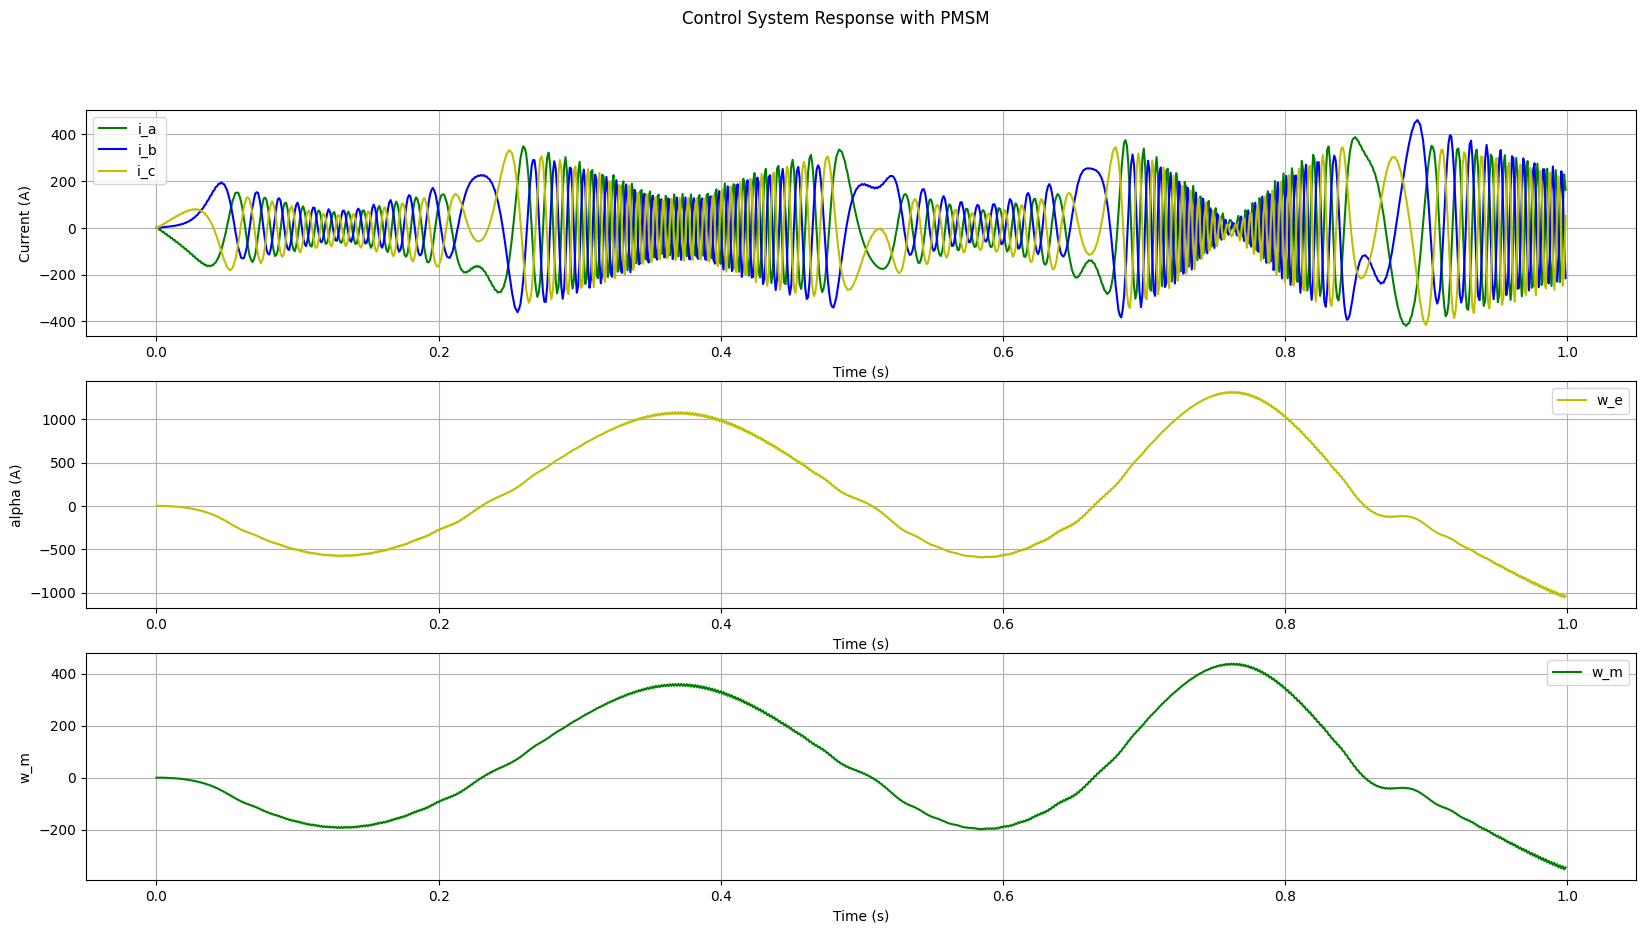

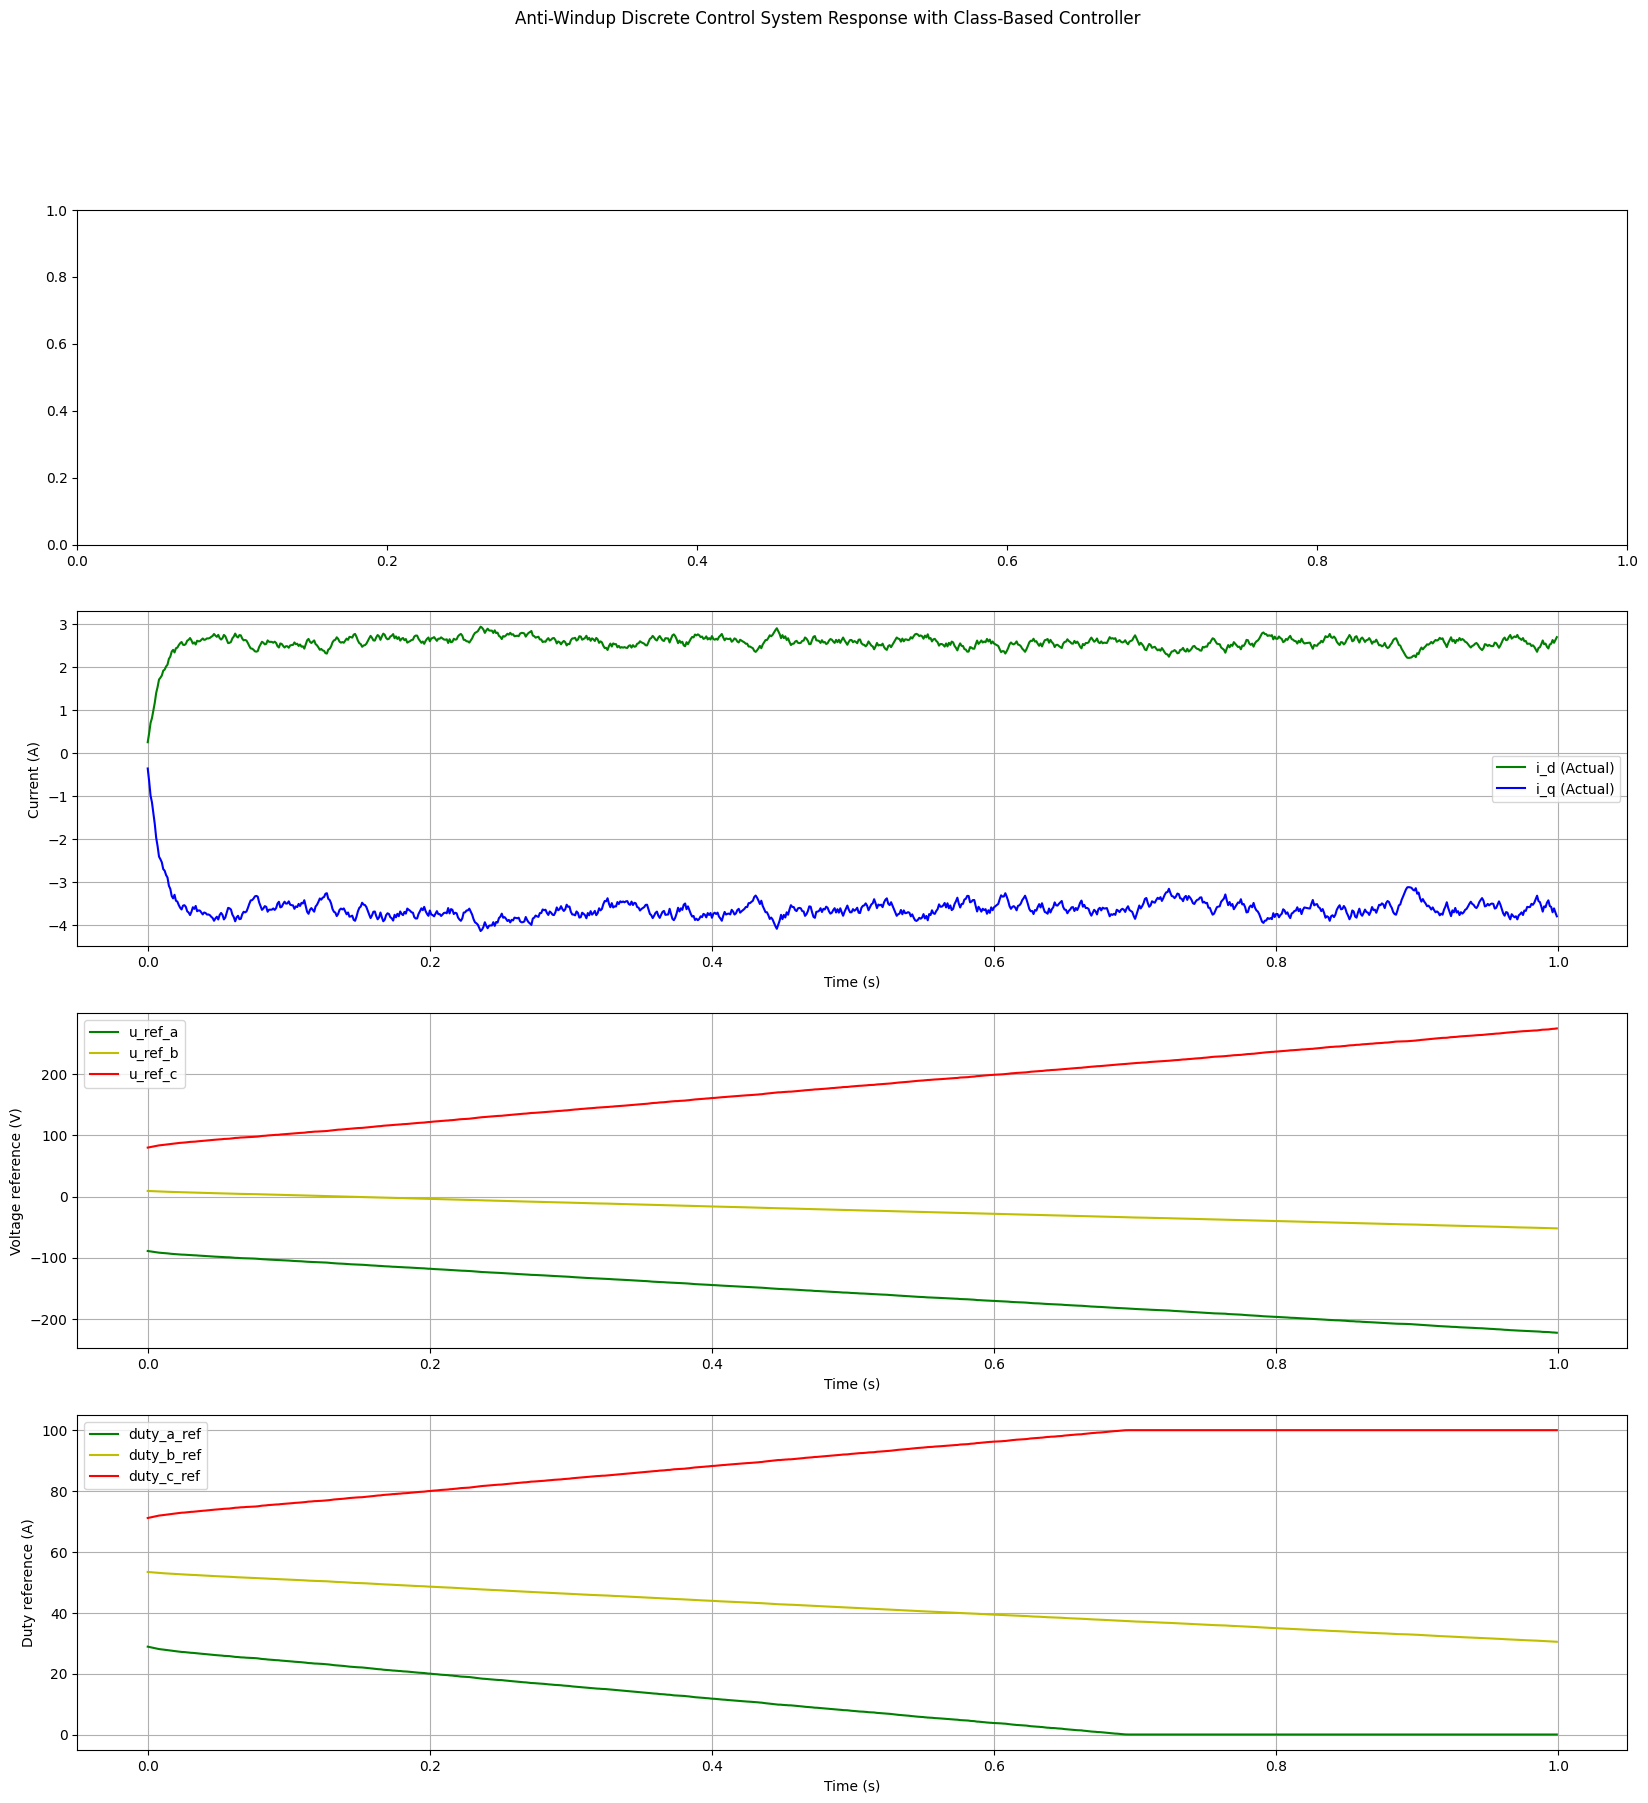

In [6]:
# --- 🌍 Global Simulation Loop ---
Ts = 0.001
T = np.arange(0, 1, Ts)  # Time vector
current = np.zeros_like(T)
rpm = np.ones_like(T)*6000

# Define **Constant** Input Signals
i_s_max = 350
t_mot_ref = 1
psi_p = 0.095
p= 3
alpha_e = 2
u_bat = 400

# Instantiate the Controller
cc = CurrentController(Ts=Ts)

svpwm = SVPWM()
pmsm = PMSM(Ts=Ts)
freq_control = FrequencyControl(Ts=Ts)

# i_d_ref_, i_q_ref_ = current_reference(i_s_max, t_mot_ref, psi_p, p)
# print(f"i_d_ref = {i_d_ref_}, i_q_ref = {i_q_ref_}")
# i_d_ref = np.ones_like(T)*i_d_ref_
# i_q_ref = np.ones_like(T)*i_q_ref_

# Global Loop Over Time
for k, t in enumerate(T):  
    # Simulate system response (mock real current behavior)
    current[k] = 0.9 * current[k-1] + 0.13 * random.uniform(2.3 * 0.5, 2.3)

# i_d, i_q = current_transformation(current, current, alpha_e)
# t_act = motor_torque(i_d, i_q)
# u_d_decoup, u_q_decoup = voltage_decoupling(1000, i_d, i_q)
    
# t_out, dc_u = control.input_output_response(cc.sys, T, [i_d_ref, i_d, u_d_decoup])
# t_out, qc_u = control.input_output_response(cc.sys, T, [i_q_ref, i_q, u_q_decoup])

# u_ref_a, u_ref_b, u_ref_c = voltage_transformation(dc_u[0], qc_u[0], alpha_e)

t_out, u = control.input_output_response(cc.sys, T, [np.ones_like(T), np.ones_like(T)*2, np.ones_like(T)*1000, current, current])
u_ref_a, u_ref_b, u_ref_c, i_d, i_q = u[0], u[1], u[2], u[3], u[4]


duty_a_ref, duty_b_ref, duty_c_ref = svpwm.duty(u_ref_a, u_ref_b, u_ref_c, u_bat)

t_out, pmsm_y = control.input_output_response(pmsm.sys, T, [duty_a_ref, duty_b_ref])

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].plot(T, pmsm_y[0], 'g', label="i_a")
axes[0].plot(T, pmsm_y[1], 'b', label="i_b")
axes[0].plot(T, pmsm_y[2], 'y', label="i_c ")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Current (A)")
axes[0].legend()
axes[0].grid()

# axes[1].plot(T, u_a, 'g', label="u_a")
# axes[1].plot(T, u_b, 'b', label="u_b")
# axes[1].plot(T, u_c, 'y', label="u_c")
axes[1].plot(T, pmsm_y[5], 'y', label="w_e")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("alpha (A)")
axes[1].legend()
axes[1].grid()

axes[2].plot(T, pmsm_y[4], 'g', label="w_m")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("w_m")
axes[2].legend()
axes[2].grid()

plt.suptitle("Control System Response with PMSM")
plt.show()

# --- 📊 Plot Results ---
fig, axes1 = plt.subplots(4, 1, figsize=(20, 20))

# axes1[0].plot(T, dc_u[0], 'g', label="u_d (Control Output)")
# axes1[0].plot(T, qc_u[0], 'y', label="u_q (Control Output)")
# axes1[0].set_xlabel("Time (s)")
# axes1[0].set_ylabel("Voltage (V)")
# axes1[0].legend()
# axes1[0].grid()

axes1[1].plot(T, i_d, 'g', label="i_d (Actual)")
axes1[1].plot(T, i_q, 'b', label="i_q (Actual)")
axes1[1].set_xlabel("Time (s)")
axes1[1].set_ylabel("Current (A)")
axes1[1].legend()
axes1[1].grid()

axes1[2].plot(T, u_ref_a, 'g', label="u_ref_a")
axes1[2].plot(T, u_ref_b, 'y', label="u_ref_b")
axes1[2].plot(T, u_ref_c, 'r', label="u_ref_c")
axes1[2].set_xlabel("Time (s)")
axes1[2].set_ylabel("Voltage reference (V)")
axes1[2].legend()
axes1[2].grid()

axes1[3].plot(T, duty_a_ref, 'g', label="duty_a_ref")
axes1[3].plot(T, duty_b_ref, 'y', label="duty_b_ref")
axes1[3].plot(T, duty_c_ref, 'r', label="duty_c_ref")
axes1[3].set_xlabel("Time (s)")
axes1[3].set_ylabel("Duty reference (A)")
axes1[3].legend()
axes1[3].grid()

plt.suptitle("Anti-Windup Discrete Control System Response with Class-Based Controller")
plt.show()

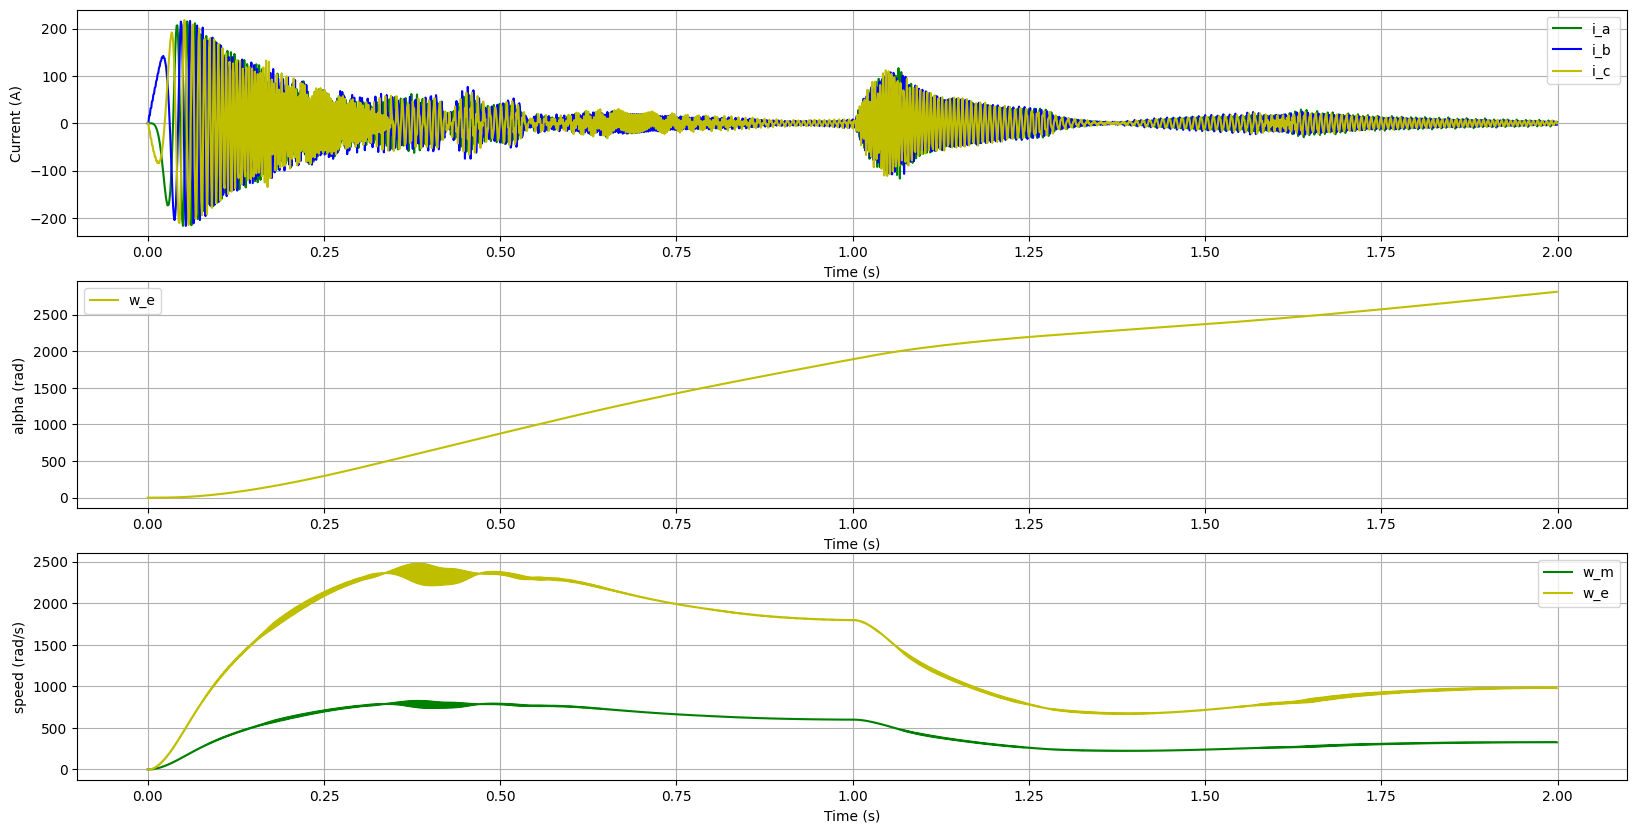

In [7]:
Ts = 0.001
T = np.arange(0, 2, Ts)  # Time vector 2s

rpm = np.ones_like(T) * 6000  # Default 6000
rpm[T >= 1] = 3000  # After 1 s set 3000

# Instantiate the Controllers
cc = CurrentController(Ts=Ts)
svpwm = SVPWM(Ts=Ts)
pmsm = PMSM(Ts=Ts)
freq_control = FrequencyControl(Ts=Ts)

system = control.InterconnectedSystem(
    (
        freq_control.sys,
        cc.sys,
        svpwm.sys,
        pmsm.sys
    ),
    connections = (
        ['freq_control.w_m', 'pmsm.w_m'],

        ['current_control.t_mot_ref', 'freq_control.u'],
        ['current_control.alpha_e', 'pmsm.alpha_e'],
        ['current_control.w_e', 'pmsm.w_e'],
        ['current_control.i_a', 'pmsm.i_a'],
        ['current_control.i_b', 'pmsm.i_b'],

        ['svpwm.u_ref_a', 'current_control.u_ref_a'],
        ['svpwm.u_ref_b', 'current_control.u_ref_b'],
        ['svpwm.u_ref_c', 'current_control.u_ref_c'],

        ['pmsm.u_a', 'svpwm.duty_a_ref'],
        ['pmsm.u_b', 'svpwm.duty_b_ref'],
    ),
    inplist = ['freq_control.w_m_ref'],
    inputs = ['w_m_ref'],
    outlist = ['pmsm.i_a', 'pmsm.i_b', 'pmsm.i_c', 'pmsm.alpha_e', 'pmsm.w_m', 'pmsm.w_e'],
    outputs = ['i_a', 'i_b', 'i_c', 'alpha_e', 'w_m', 'w_e']
)

t_out, pmsm = control.input_output_response(system, T, [rpm])

fig, axes = plt.subplots(3, 1, figsize=(20, 10))

axes[0].plot(T, pmsm[0], 'g', label="i_a")
axes[0].plot(T, pmsm[1], 'b', label="i_b")
axes[0].plot(T, pmsm[2], 'y', label="i_c ")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Current (A)")
axes[0].legend()
axes[0].grid()

axes[1].plot(T, pmsm[3], 'y', label="w_e")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("alpha (rad)")
axes[1].legend()
axes[1].grid()

axes[2].plot(T, pmsm[4], 'g', label="w_m")
axes[2].plot(T, pmsm[5], 'y', label="w_e")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("speed (rad/s)")
axes[2].legend()
axes[2].grid()